In [1]:
import os
import time
import torch
import argparse
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.multiprocessing as mp
import torch.utils.data
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn

from models import VAE


device = torch.device('cpu')

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
# train_data = datasets.MNIST(root='data', train=True,
#                                    download=True, transform=transform)
# test_data = datasets.MNIST(root='data', train=False,
#                                   download=True, transform=transform)

# data_loader = DataLoader(
#     dataset=dataset, batch_size=args.batch_size, shuffle=True)
# print(len(train_data))

dataset = MNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)


print(type(dataset))

# for images in t
# images = images.view(images.size(0), -1)

<class 'torchvision.datasets.mnist.MNIST'>


In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32


valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
# train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_workers,sampler=train_sampler)
# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,sampler=valid_sampler)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
train_loader = data_loader
valid_loader = data_loader
test_loader = data_loader
# train_loader = torch.utils.data.DataLoader(data_loader,batch_size=batch_size,num_workers=num_workers,sampler=train_sampler)
# valid_loader = torch.utils.data.DataLoader(data_loader, batch_size=batch_size, num_workers=num_workers,sampler=valid_sampler)
# test_loader = torch.utils.data.DataLoader(data_loader, batch_size=batch_size, num_workers=num_workers)

# print(len(train_loader))
# print(len(valid_loader))
# print(len(test_loader))

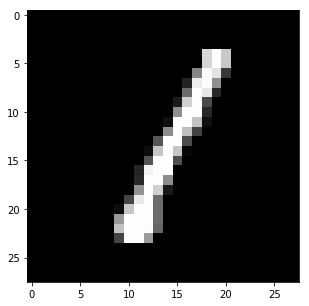

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

Loss function
--------------------



In [4]:
def loss_fn(recon_x, x, mean, log_var):
#     criterion = nn.BCEWithLogitsLoss(reduction='sum')
#     BCE = criterion(recon_x, x) / len(x)

#     recon_x = torch.clamp(recon_x, 0, 1)
#     x = torch.clamp(x, 0, 1) 
    
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # elbo = recon_loss + self.beta * D_kl
    elbo = (BCE + KLD)/ x.size(0)
    return elbo

In [5]:
seed = 0
epochs = 20
latent_size = 2
num_processes = 2
learning_rate = 0.001
print_every = 100
encoder_layer_sizes=[784, 256]
decoder_layer_sizes=[256, 784]

vae = VAE(latent_size=latent_size).float().to(device)

# vae = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes).to(device)

use_cuda = torch.cuda.is_available
if use_cuda:
    vae.to(device)

logs = defaultdict(list)
    
epochs = epochs
for epoch in range(epochs):
    lr_havel = learning_rate
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr_havel)
    
    for iteration, data in enumerate(train_loader):
        images, _ = data
        images = images.view(images.size(0), -1)
        if use_cuda:
            images = images.to(device).float()
        else:
            images = images.float()

        optimizer.zero_grad()
        recon_x, mean, log_var, z = vae(images)
        elbo = loss_fn(recon_x, images, mean, log_var)
        loss = elbo
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())

        if iteration % print_every == 0 or iteration == len(train_loader)-1:
            valid_correct = 0
            valid_total = 0
            test_correct = 0
            test_total = 0

            for valid_data in valid_loader:
                valid, _ = valid_data
                valid = images.view(valid.size(0), -1)
                if use_cuda:
                    input_valid = valid.to(device).float()
                else:
                    input_valid = valid.float()
                valid_recon_x, valid_mean, valid_log_var, valid_z = vae(input_valid)
                valid_elbo = loss_fn(valid_recon_x, input_valid, valid_mean, valid_log_var)
                criterion = nn.MSELoss()
                valid_loss = criterion(valid_recon_x, input_valid)
                logs['valid_elbo'].append(valid_elbo.item())
                logs['valid_loss'].append(valid_loss.item())
                valid_total +=1
                if valid_loss < 0.05:
                    valid_correct += 1
            valid_acc = valid_correct / valid_total  
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d} |Train_ELBO {:5f} |Valid_ELBO{:5f} |Valid_loss{:5f} |Valid_accuary{:5f} |Leaarning_rate{:5f}".format(
                epoch, epochs, iteration, len(train_loader)-1, loss.item(), valid_elbo.item(), valid_loss.item(), valid_acc, lr_havel))

    lr_havel = lr_havel*0.9
    torch.save(vae, 'vae_mnist_binary_cross_entropy.pkl')  

Epoch 00/20 Batch 0000/1874 |Train_ELBO 563.360229 |Valid_ELBO562.949890 |Valid_loss0.241547 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/20 Batch 0100/1874 |Train_ELBO 280.285614 |Valid_ELBO267.442902 |Valid_loss0.075486 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/20 Batch 0200/1874 |Train_ELBO 189.597977 |Valid_ELBO190.597733 |Valid_loss0.056047 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/20 Batch 0300/1874 |Train_ELBO 195.964371 |Valid_ELBO196.934769 |Valid_loss0.061029 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/20 Batch 0400/1874 |Train_ELBO 189.333344 |Valid_ELBO189.589600 |Valid_loss0.058761 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/20 Batch 0500/1874 |Train_ELBO 169.317169 |Valid_ELBO170.522430 |Valid_loss0.050050 |Valid_accuary0.222400 |Leaarning_rate0.001000
Epoch 00/20 Batch 0600/1874 |Train_ELBO 180.627808 |Valid_ELBO183.655106 |Valid_loss0.056050 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/20 Batch 07

Epoch 02/20 Batch 1874/1874 |Train_ELBO 167.075745 |Valid_ELBO167.520157 |Valid_loss0.049858 |Valid_accuary0.940267 |Leaarning_rate0.001000
Epoch 03/20 Batch 0000/1874 |Train_ELBO 179.685577 |Valid_ELBO176.142822 |Valid_loss0.051987 |Valid_accuary0.000533 |Leaarning_rate0.001000
Epoch 03/20 Batch 0100/1874 |Train_ELBO 187.264023 |Valid_ELBO183.897308 |Valid_loss0.054383 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 03/20 Batch 0200/1874 |Train_ELBO 174.256104 |Valid_ELBO177.537781 |Valid_loss0.053858 |Valid_accuary0.000533 |Leaarning_rate0.001000
Epoch 03/20 Batch 0300/1874 |Train_ELBO 175.547134 |Valid_ELBO172.470367 |Valid_loss0.051061 |Valid_accuary0.017600 |Leaarning_rate0.001000
Epoch 03/20 Batch 0400/1874 |Train_ELBO 177.697403 |Valid_ELBO176.693573 |Valid_loss0.053780 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 03/20 Batch 0500/1874 |Train_ELBO 171.751663 |Valid_ELBO173.218002 |Valid_loss0.051540 |Valid_accuary0.000533 |Leaarning_rate0.001000
Epoch 03/20 Batch 06

Epoch 05/20 Batch 1800/1874 |Train_ELBO 177.276627 |Valid_ELBO176.727173 |Valid_loss0.051471 |Valid_accuary0.025600 |Leaarning_rate0.001000
Epoch 05/20 Batch 1874/1874 |Train_ELBO 188.237885 |Valid_ELBO183.513718 |Valid_loss0.055102 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 06/20 Batch 0000/1874 |Train_ELBO 164.798386 |Valid_ELBO162.965363 |Valid_loss0.047749 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 06/20 Batch 0100/1874 |Train_ELBO 164.850983 |Valid_ELBO165.907761 |Valid_loss0.047564 |Valid_accuary0.999467 |Leaarning_rate0.001000
Epoch 06/20 Batch 0200/1874 |Train_ELBO 159.819550 |Valid_ELBO160.471725 |Valid_loss0.046171 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 06/20 Batch 0300/1874 |Train_ELBO 191.635849 |Valid_ELBO192.332153 |Valid_loss0.057389 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 06/20 Batch 0400/1874 |Train_ELBO 179.402756 |Valid_ELBO178.424881 |Valid_loss0.054991 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 06/20 Batch 05

Epoch 08/20 Batch 1700/1874 |Train_ELBO 170.874634 |Valid_ELBO168.892273 |Valid_loss0.050332 |Valid_accuary0.053333 |Leaarning_rate0.001000
Epoch 08/20 Batch 1800/1874 |Train_ELBO 167.804642 |Valid_ELBO166.849823 |Valid_loss0.049060 |Valid_accuary0.945067 |Leaarning_rate0.001000
Epoch 08/20 Batch 1874/1874 |Train_ELBO 182.824051 |Valid_ELBO182.950500 |Valid_loss0.054252 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 09/20 Batch 0000/1874 |Train_ELBO 185.153061 |Valid_ELBO187.053085 |Valid_loss0.055885 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 09/20 Batch 0100/1874 |Train_ELBO 180.989777 |Valid_ELBO182.375458 |Valid_loss0.056191 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 09/20 Batch 0200/1874 |Train_ELBO 176.366592 |Valid_ELBO176.090057 |Valid_loss0.052200 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 09/20 Batch 0300/1874 |Train_ELBO 159.488708 |Valid_ELBO157.977234 |Valid_loss0.045621 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 09/20 Batch 04

Epoch 11/20 Batch 1600/1874 |Train_ELBO 174.752747 |Valid_ELBO174.350143 |Valid_loss0.051277 |Valid_accuary0.011733 |Leaarning_rate0.001000
Epoch 11/20 Batch 1700/1874 |Train_ELBO 172.061829 |Valid_ELBO173.119461 |Valid_loss0.050898 |Valid_accuary0.109867 |Leaarning_rate0.001000
Epoch 11/20 Batch 1800/1874 |Train_ELBO 190.503616 |Valid_ELBO195.213242 |Valid_loss0.059893 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 11/20 Batch 1874/1874 |Train_ELBO 168.570389 |Valid_ELBO169.677277 |Valid_loss0.050757 |Valid_accuary0.067733 |Leaarning_rate0.001000
Epoch 12/20 Batch 0000/1874 |Train_ELBO 171.388107 |Valid_ELBO172.171371 |Valid_loss0.051487 |Valid_accuary0.054933 |Leaarning_rate0.001000
Epoch 12/20 Batch 0100/1874 |Train_ELBO 163.525208 |Valid_ELBO162.019669 |Valid_loss0.047135 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 12/20 Batch 0200/1874 |Train_ELBO 170.423508 |Valid_ELBO171.354416 |Valid_loss0.051451 |Valid_accuary0.001067 |Leaarning_rate0.001000
Epoch 12/20 Batch 03

Epoch 14/20 Batch 1500/1874 |Train_ELBO 170.838486 |Valid_ELBO166.817413 |Valid_loss0.048425 |Valid_accuary0.770133 |Leaarning_rate0.001000
Epoch 14/20 Batch 1600/1874 |Train_ELBO 176.564957 |Valid_ELBO180.481247 |Valid_loss0.052833 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 14/20 Batch 1700/1874 |Train_ELBO 174.448608 |Valid_ELBO174.148132 |Valid_loss0.052674 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 14/20 Batch 1800/1874 |Train_ELBO 180.433456 |Valid_ELBO181.680984 |Valid_loss0.054227 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 14/20 Batch 1874/1874 |Train_ELBO 171.490662 |Valid_ELBO172.259949 |Valid_loss0.051151 |Valid_accuary0.004267 |Leaarning_rate0.001000
Epoch 15/20 Batch 0000/1874 |Train_ELBO 167.286362 |Valid_ELBO166.716217 |Valid_loss0.047745 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 15/20 Batch 0100/1874 |Train_ELBO 186.302658 |Valid_ELBO185.934586 |Valid_loss0.055581 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 15/20 Batch 02

Epoch 17/20 Batch 1400/1874 |Train_ELBO 165.753204 |Valid_ELBO168.032196 |Valid_loss0.048867 |Valid_accuary0.993067 |Leaarning_rate0.001000
Epoch 17/20 Batch 1500/1874 |Train_ELBO 162.831940 |Valid_ELBO163.565674 |Valid_loss0.047931 |Valid_accuary0.982400 |Leaarning_rate0.001000
Epoch 17/20 Batch 1600/1874 |Train_ELBO 167.035522 |Valid_ELBO168.938202 |Valid_loss0.050295 |Valid_accuary0.749333 |Leaarning_rate0.001000
Epoch 17/20 Batch 1700/1874 |Train_ELBO 176.039108 |Valid_ELBO176.607147 |Valid_loss0.053725 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 17/20 Batch 1800/1874 |Train_ELBO 168.604324 |Valid_ELBO169.597977 |Valid_loss0.050109 |Valid_accuary0.803200 |Leaarning_rate0.001000
Epoch 17/20 Batch 1874/1874 |Train_ELBO 169.542755 |Valid_ELBO167.908432 |Valid_loss0.048996 |Valid_accuary0.554667 |Leaarning_rate0.001000
Epoch 18/20 Batch 0000/1874 |Train_ELBO 175.987869 |Valid_ELBO173.677643 |Valid_loss0.051622 |Valid_accuary0.100800 |Leaarning_rate0.001000
Epoch 18/20 Batch 01

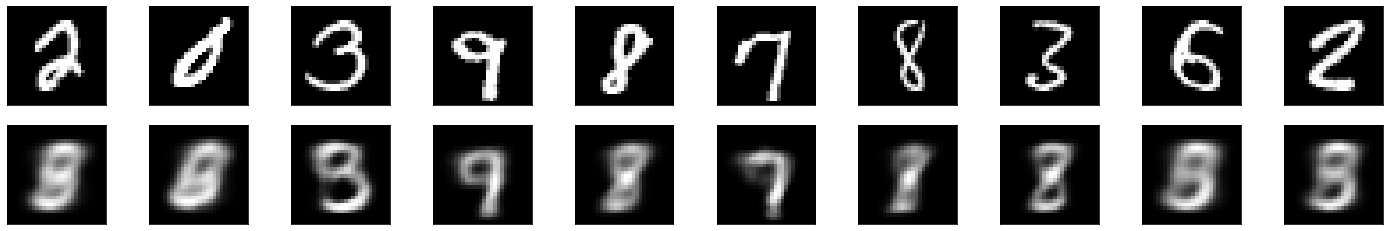

In [6]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# images = images.to(device)
images_flatten = images.view(images.size(0), -1).to(device)
# get sample outputs
test_recon_x, test_mean, test_log_var, test_z = vae(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = test_recon_x
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

tensor([[-0.4746, -0.8229],
        [-0.1443, -2.3560],
        [ 1.0759,  1.0061],
        [ 0.7944,  0.6321],
        [-1.2018,  0.2330],
        [-1.6880,  0.8055],
        [-0.1181,  0.7130],
        [-0.2482, -0.9035],
        [ 0.3501,  1.2849],
        [-0.6698,  0.9038],
        [-0.5913,  1.0384],
        [ 1.0469, -0.0834],
        [ 0.9148, -1.1083],
        [-0.9567,  0.5689],
        [-0.8168, -0.2396],
        [ 0.7440, -1.6455],
        [-0.8889,  0.2076],
        [ 1.2632, -1.6865],
        [-0.3888,  1.1150],
        [-0.9799, -0.2948],
        [-1.0493, -0.8613],
        [-0.9072, -0.4811],
        [-0.8640, -0.0905],
        [ 1.0491, -0.3539],
        [-0.4534, -0.0087],
        [-1.6958,  1.9592],
        [ 1.2249, -2.2407],
        [-0.3212,  0.5745],
        [ 0.0683, -0.8024],
        [-0.4023, -0.3792],
        [-0.1840, -1.5797],
        [ 0.2405,  1.7797]])


ValueError: num must be 1 <= num <= 20, not 21

<Figure size 432x288 with 0 Axes>

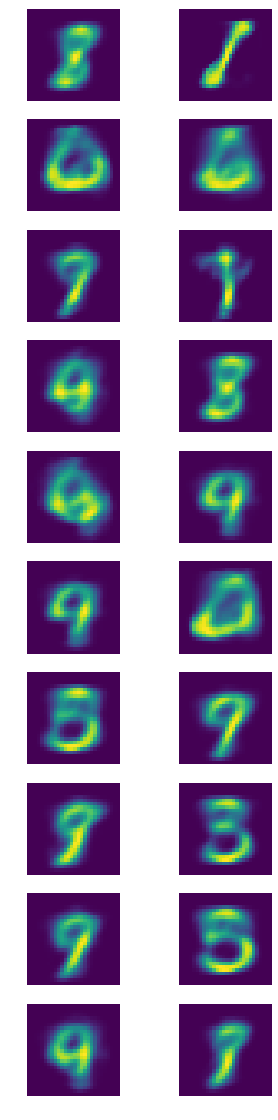

In [7]:
z = torch.randn([batch_size, 2]).cpu()

print(z)

# recon_x = vae.decoder(z, c=None)
recon_x = vae.decoder(z)

plt.figure()
plt.figure(figsize=(5, 20))
for p in range(batch_size):
    plt.subplot(10, 2, p+1)
    plt.imshow(recon_x[p].view(28, 28).data.numpy())
    plt.axis('off')